In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      /opt/conda/lib/python3.10/site-packages/setuptools/config/setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
      !!
      
              ********************************************************************************
              The license_file parameter is deprecated, use license_files instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
        parsed = self.parsers.get(

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  2.0.0
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import json
# Given COCO train dataset has no segmentation information so from the bounding box information segmentation information is formed
# Load your COCO dataset annotations
with open('/kaggle/input/qrcode/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Iterate through annotations and convert bounding box to segmentation
for annotation in coco_data['annotations']:
    bbox = annotation['bbox']

    x_min, y_min, width, height = bbox
    x_max, y_max = x_min + width, y_min + height

    # Update the 'segmentation' field with rectangular segmentation
    annotation['segmentation'] = [[x_min, y_min, x_min, y_max, x_max, y_max, x_max, y_min]]

output_file_path = '/kaggle/working/updated_coco_annotations_train.json'
with open(output_file_path, 'w') as f:
    json.dump(coco_data, f)

In [ ]:
# Given COCO test dataset has no segmentation information so from the bounding box information segmentation information is formed
# Load your COCO dataset annotations
with open('/kaggle/input/qrcode/test/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Iterate through annotations and convert bounding box to segmentation
for annotation in coco_data['annotations']:
    bbox = annotation['bbox']

    x_min, y_min, width, height = bbox
    x_max, y_max = x_min + width, y_min + height

    # Update the 'segmentation' field with rectangular segmentation
    annotation['segmentation'] = [[x_min, y_min, x_min, y_max, x_max, y_max, x_max, y_min]]

output_file_path = '/kaggle/working/updated_coco_annotations_test.json'
with open(output_file_path, 'w') as f:
    json.dump(coco_data, f)

In [ ]:
#If the dataset is in COCO format, then registering the QR code data can be done using this line of code:
from detectron2.data.datasets import register_coco_instances
#while registering the data a name is mentioned here for train data "train_nn8", then path of coco train dataset is mentioned and the path where all the train data image is present
register_coco_instances("train_nn8", {}, "/kaggle/working/updated_coco_annotations_train.json", "/kaggle/input/qrcode/train")
register_coco_instances("test_nn8", {}, "/kaggle/working/updated_coco_annotations_test.json", "/kaggle/input/qrcode/test")
MetadataCatalog.get("train_nn8").set(thing_classes=['qrcode', 'QR_CODE'])
MetadataCatalog.get("test_nn8").set(thing_classes=['qrcode', 'QR_CODE'])

namespace(name='test_nn8',
          json_file='/kaggle/working/updated_coco_annotations_test.json',
          image_root='/kaggle/input/qrcode/test',
          evaluator_type='coco',
          thing_classes=['qrcode', 'QR_CODE'])

In [ ]:

dataset_dicts = DatasetCatalog.get("train_nn8")

In [ ]:
metadata_train = MetadataCatalog.get("train_nn8")
print(metadata_train)

Metadata(name='train_nn8', json_file='/kaggle/working/updated_coco_annotations_train.json', image_root='/kaggle/input/qrcode/train', evaluator_type='coco', thing_classes=['qrcode', 'QR_CODE'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1})


WARNING [11/13 10:59:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/13 10:59:53 d2.data.datasets.coco]: Loaded 502 images in COCO format from /kaggle/working/updated_coco_annotations_train.json


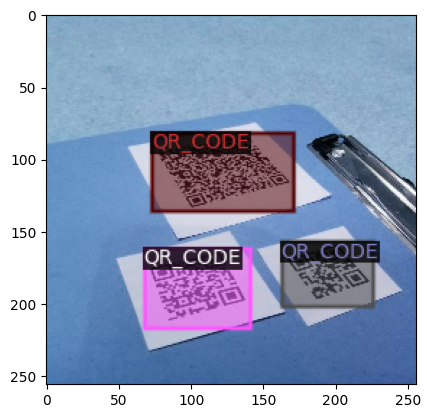

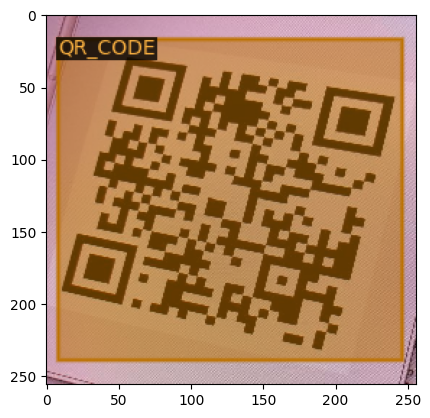

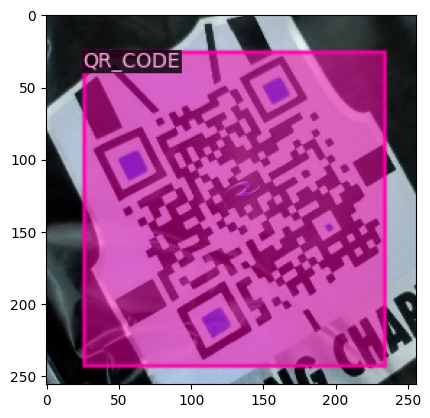

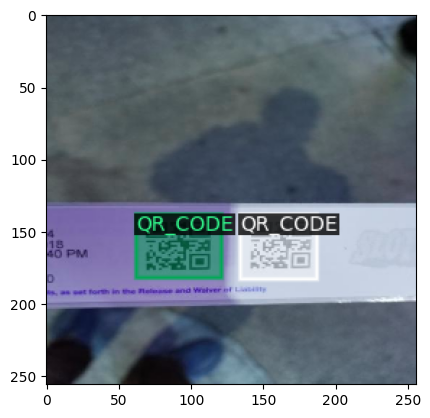

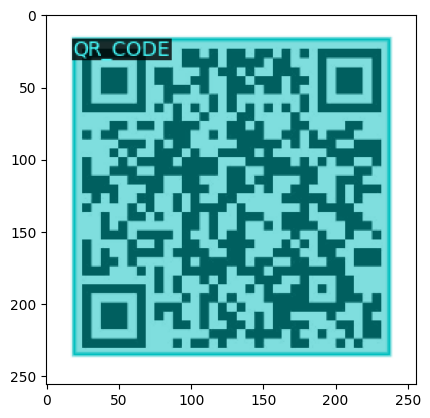

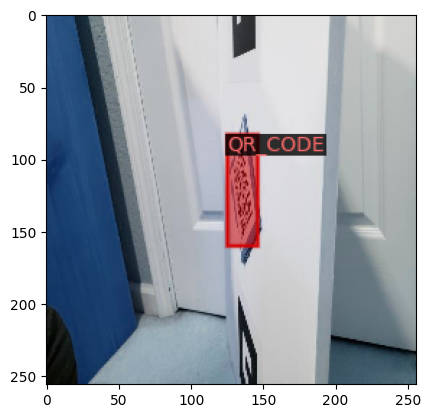

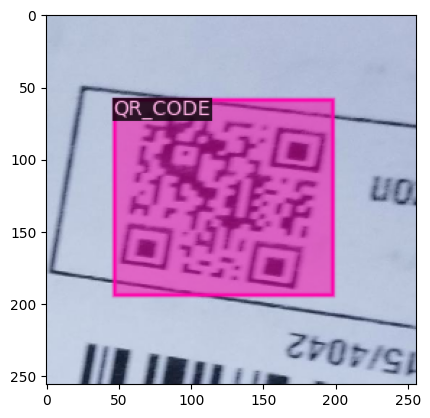

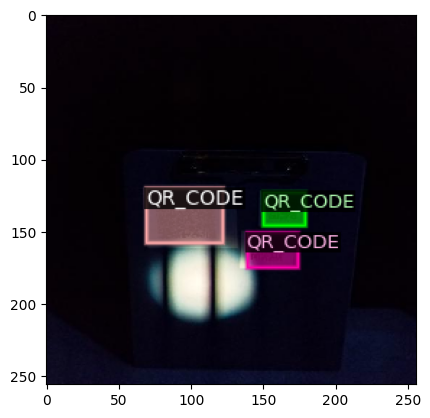

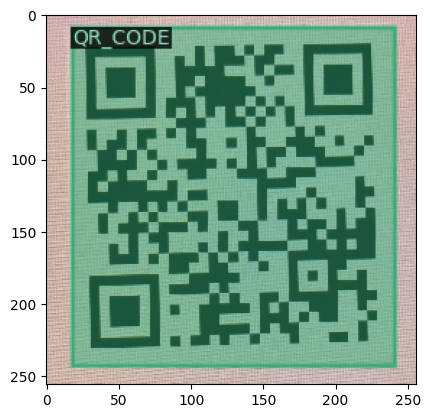

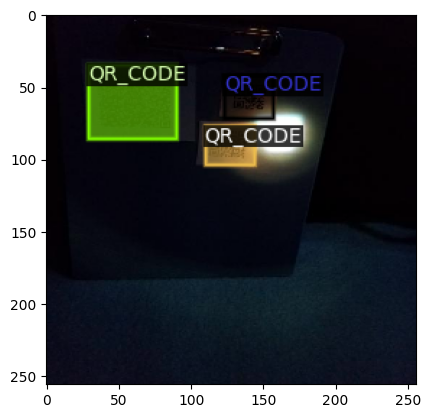

In [ ]:
import cv2
import matplotlib.pyplot as plt
#Visualizing the train data with the metadata information
dataset_dicts = DatasetCatalog.get("train_nn8")
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_train, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer
#Model training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_nn8",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.IMS_PER_BATCH = 2
#0.00025  # pick a good LR
cfg.SOLVER.BASE_LR =0.00025
# 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.MAX_ITER = 300
# do not decay learning rate
cfg.SOLVER.STEPS = []
# The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#  Has two class ['qrcode', 'QR_CODE']. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/13 11:00:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:08, 21.4MB/s]                              


[11/13 11:00:43 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/13 11:00:55 d2.utils.events]:  eta: 0:00:58  iter: 19  total_loss: 2.162  loss_cls: 0.9486  loss_box_reg: 0.5097  loss_mask: 0.6924  loss_rpn_cls: 0.03151  loss_rpn_loc: 0.009745    time: 0.2132  last_time: 0.2076  data_time: 0.0114  last_data_time: 0.0055   lr: 1.6068e-05  max_mem: 1942M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[11/13 11:01:11 d2.utils.events]:  eta: 0:00:53  iter: 39  total_loss: 1.952  loss_cls: 0.6887  loss_box_reg: 0.5426  loss_mask: 0.6083  loss_rpn_cls: 0.0205  loss_rpn_loc: 0.01263    time: 0.2502  last_time: 0.2097  data_time: 0.0055  last_data_time: 0.0062   lr: 3.2718e-05  max_mem: 1947M
[11/13 11:01:15 d2.utils.events]:  eta: 0:00:48  iter: 59  total_loss: 1.546  loss_cls: 0.4723  loss_box_reg: 0.5371  loss_mask: 0.4995  loss_rpn_cls: 0.01219  loss_rpn_loc: 0.009045    time: 0.2334  last_time: 0.1970  data_time: 0.0061  last_data_time: 0.0059   lr: 4.9367e-05  max_mem: 1947M
[11/13 11:01:19 d2.utils.events]:  eta: 0:00:44  iter: 79  total_loss: 1.347  loss_cls: 0.3923  loss_box_reg: 0.5143  loss_mask: 0.4216  loss_rpn_cls: 0.007453  loss_rpn_loc: 0.009066    time: 0.2257  last_time: 0.1962  data_time: 0.0056  last_data_time: 0.0056   lr: 6.6017e-05  max_mem: 1947M
[11/13 11:01:23 d2.utils.events]:  eta: 0:00:40  iter: 99  total_loss: 1.275  loss_cls: 0.2999  loss_box_reg: 0.5582  l

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")             # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7                                     # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/13 11:02:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
metadata_test = MetadataCatalog.get("test_nn8")


In [ ]:
dataset_dicts = DatasetCatalog.get("test_nn8")


WARNING [11/13 11:03:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/13 11:03:11 d2.data.datasets.coco]: Loaded 60 images in COCO format from /kaggle/working/updated_coco_annotations_test.json


WARNING [11/13 11:03:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/13 11:03:22 d2.data.datasets.coco]: Loaded 60 images in COCO format from /kaggle/working/updated_coco_annotations_test.json


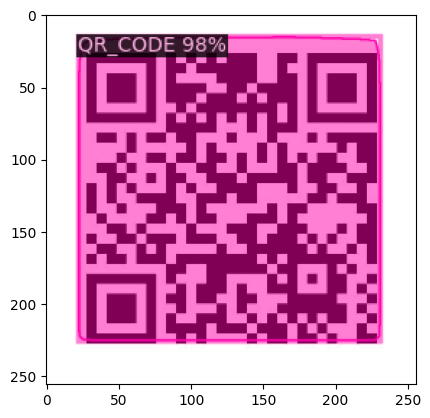

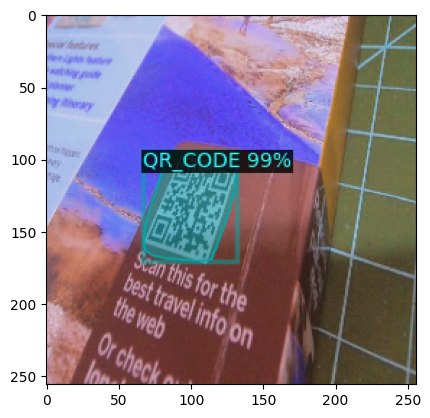

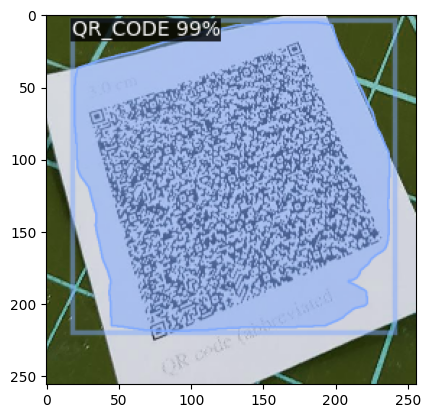

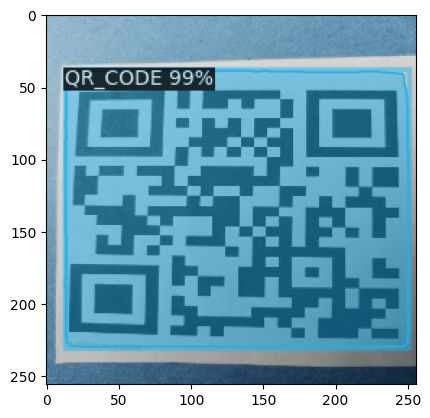

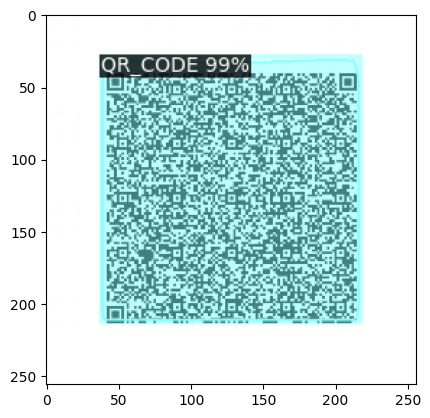

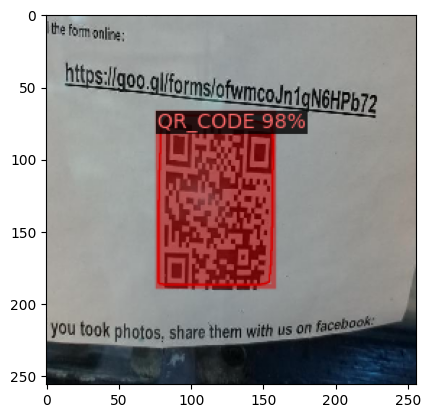

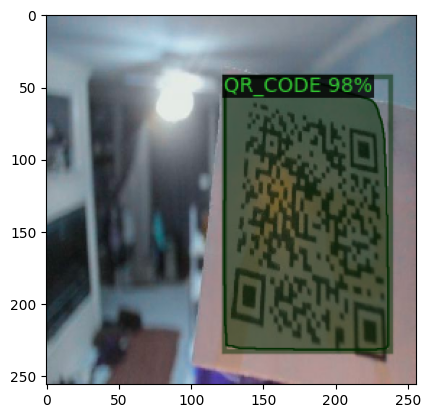

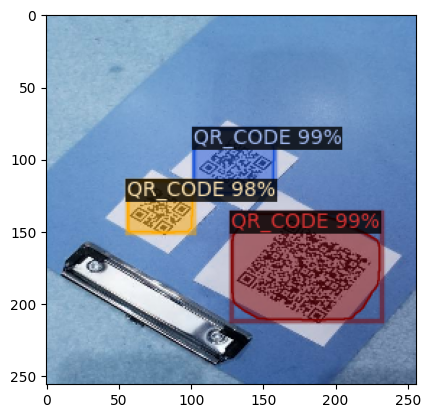

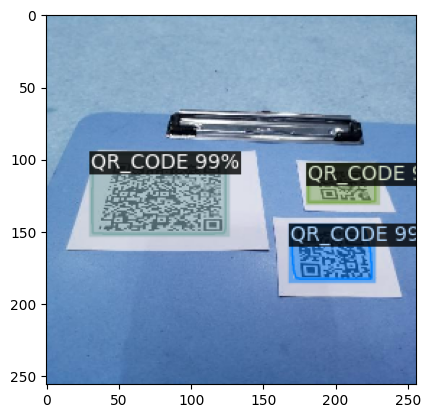

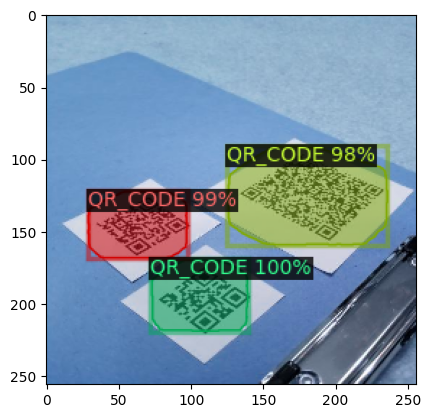

In [ ]:
#visualizing the output test data result
dataset_dicts = DatasetCatalog.get("test_nn8")
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=metadata_train, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()